<a href="https://colab.research.google.com/github/junhyeokk/boomhill24/blob/main/model/baseline-model-training8-many-to-many.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import os
import csv
import random
import numpy as np
from PIL import Image as PIL_Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from torch.autograd import Variable

from torchvision import transforms
from torchvision.models import resnet50, resnet152

# 랜덤 시드 고정

In [ ]:
seed = 400

os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)    
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
drivepath = "/content/gdrive/MyDrive"

In [ ]:
device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)
print(device)

cuda


# 모델과 그에 맞는 데이터셋 설정

Convolution layer의 출력을 FC layer에 통과시킨 뒤 매 타임스탭마다 이미지를 입력받아 키 입력을 출력하는 다대일 lstm 모델을 구성합니다. 이후 학습에서 Languagd Model 학습에서처럼 매 타임스탭마다 loss를 발생시켜 역전파시키는 방식으로 학습시킵니다.

In [ ]:
class KartModel8(nn.Module):
  def __init__(self, num_class = 64, cnn_to_lstm = 1024, lstm_hidden = 512, num_layers = 5):
    super(KartModel8, self).__init__()
    self.num_class = num_class
    self.num_layers = num_layers
    self.hidden_size = lstm_hidden

    self.resnet_minimap = resnet50(pretrained=True)
    self.resnet_minimap.fc = nn.Sequential(
      nn.Linear(in_features=2048, out_features=cnn_to_lstm, bias=True),
      nn.ReLU(),
    )
    self.lstm_minimap = nn.LSTM(
        input_size = cnn_to_lstm,
        hidden_size = lstm_hidden,
        num_layers = num_layers,
        batch_first = True,
        dropout = 0.3,
    )

    self.resnet_game = resnet50(pretrained=True)
    self.resnet_game.fc = nn.Sequential(
        nn.Linear(in_features=2048, out_features=cnn_to_lstm, bias=True),
        nn.ReLU(),
    )
    self.lstm_game = nn.LSTM(
        input_size = cnn_to_lstm,
        hidden_size = lstm_hidden,
        num_layers = num_layers,
        batch_first = True,
        dropout = 0.3,
    )

    self.lstm_features = nn.LSTM(
        input_size = 7,
        hidden_size = lstm_hidden,
        num_layers = num_layers,
        batch_first = True,
        dropout = 0.3,
    )

    self.fc_1 = nn.Linear(lstm_hidden * 3, lstm_hidden * 2)
    self.bn1 = nn.BatchNorm1d(lstm_hidden * 2)
    self.relu = nn.ReLU()
    self.fc_2 = nn.Linear(lstm_hidden * 2, lstm_hidden)
    self.bn2 = nn.BatchNorm1d(lstm_hidden)
    self.fc_3 = nn.Linear(lstm_hidden, num_class)
    # self.sigmoid = nn.Sigmoid()

  # 전체 게임화면, 미니맵, 속도, 이전입력
  def forward(self, games, minimaps, speeds, key_inputs,
              hidden1 = None, hidden2 = None, hidden3 = None):
    for t in range(minimaps.size(1)):
      # with torch.no_grad():
      x1 = self.resnet_minimap(minimaps[:, t, :, :, :])
      out1, hidden1 = self.lstm_minimap(x1.unsqueeze(1), hidden1)
    # batch first = True
    # batch, seq, hidden_size

    for t in range(games.size(1)):
      x2 = self.resnet_game(games[:, t, :, :, :])
      out2, hidde2 = self.lstm_game(x2.unsqueeze(1), hidden2)

    out3, hidden3 = self.lstm_features(torch.cat([key_inputs, speeds], dim=2), hidden3)
    # batch, seq, features

    out = self.fc_1(torch.cat([out1[:, -1, :], out2[:, -1, :], out3[:, -1, :]], dim=1))
    # 마지막 sequence
    out = self.bn1(out)
    out = self.relu(out)
    out = self.fc_2(out)
    out = self.bn2(out)
    out = self.relu(out)
    out = self.fc_3(out)
    # out = self.sigmoid(out)

    return out, hidden1, hidden2, hidden3

In [ ]:
seq_size = 10

In [ ]:
class KartDataSet8(data.Dataset):
  def __init__(self, csv_files):
    self.image_seqs = []
    self.minimap_seqs = []
    self.speed_seqs = []
    self.label_seqs = []

    for csv_file in csv_files:
      images = []
      minimaps = []
      speeds = []
      labels = []

      with open(csv_file) as csvfile:
        csv_reader = csv.reader(csvfile)
        next(csv_reader, None)        # 첫번째 row 스킵
        
        for row in csv_reader:
          images.append(drivepath + '/' + row[0])
          minimaps.append(drivepath + '/' + row[1])
          speeds.append([int(row[2]) / 300])
          # 대략 0~1 정도로 정규화 : 최고속도를 300이라 가정
          labels.append([int(x) for x in list(row[3])])
          # 10진수로 encode
          
      for i in range(len(images)):
        if i - seq_size > 0:
          # self.image_seqs.append(images[i - seq_size + 1:i + 1])
          # 하나 적게
          self.image_seqs.append(images[i - seq_size:i])
          self.minimap_seqs.append(minimaps[i - seq_size:i])
          self.speed_seqs.append(speeds[i - seq_size:i])
          # self.label_seqs.append(labels[i - seq_size:i + 1])
          self.label_seqs.append(labels[i - seq_size - 1:i])

  def __getitem__(self, index):
    image_paths = self.image_seqs[index]
    images = [PIL_Image.open(image_path) for image_path in image_paths]
    minimap_paths = self.minimap_seqs[index]
    minimaps = [PIL_Image.open(minimap_path) for minimap_path in minimap_paths]
    speeds = self.speed_seqs[index]
    labels = self.label_seqs[index]
    preprocessed_labels = []
    # 다대다 학습때 한칸씩 비껴서 할수 있도록
    # 입력은 [0:-1]로, 출력은 [1:]로
    # 입력은 labels, 출력은 preprocessed_labels
    # 입력은 000000 ~ 111111, 출력은 0~63
    for label in labels[1:]:
      preprocessed_labels.append(int(''.join(map(str, label)), 2))

    preprocess = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),     # -1 ~ 1 로 normalize
    ])

    preprocessed_images = []
    for img in images:
      preprocessed_images.append(preprocess(img))
    
    preprocessed_minimaps = []
    for minimap in minimaps:
      preprocessed_minimaps.append(preprocess(minimap))
    
    # return torch.stack(preprocessed_images), torch.Tensor(labels[:-1]), torch.tensor(preprocessed_labels, dtype=torch.long)
    return torch.stack(preprocessed_images), torch.stack(preprocessed_minimaps), torch.Tensor(speeds), torch.Tensor(labels[:-1]), torch.tensor(preprocessed_labels, dtype=torch.long)
    # 전체 게임화면, 미니맵, 속도, 이전입력, 정답 레이블

  def __len__(self):
    return len(self.image_seqs)

In [ ]:
train_csvs = [f"{drivepath}/csv/kart_test_minimap_mark3_{str(i)}.csv" for i in range(4)]
validation_csv = [f"{drivepath}/csv/kart_test_minimap_mark3_4.csv"]
train_dataset = KartDataSet8(train_csvs)
validation_dataset = KartDataSet8(validation_csv)
# test
print(train_dataset[0][0].shape)
# seq, channel, width, height
print(train_dataset[100][1].shape)
# 입력
print(train_dataset[1][2])
# 속도
print(train_dataset[100][3])
# 이전 입력

torch.Size([10, 3, 224, 224])
torch.Size([10, 3, 224, 224])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
tensor([[1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0., 0.],
        [1., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.]])


# 하이퍼 파라미터 설정

In [ ]:
num_epochs = 10
lr = 1e-4
batch_size = 4
log_interval = 10

In [ ]:
train_loader = data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=4,
    shuffle=True,
    drop_last=True,
)

validation_loader = data.DataLoader(
    validation_dataset,
    batch_size=batch_size,
    num_workers=4,
    shuffle=False,
    drop_last=True,
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(len(train_loader))
print(len(train_dataset))
print(len(validation_loader))
print(len(validation_dataset))

1053
4212
264
1058


# 모델 저장 설정 및 학습 가능한 레이어 확인

In [ ]:
save_path = drivepath + "/test_model_minimap8.pt"

model = KartModel8()
# model.load_state_dict(torch.load(save_path))
model = model.to(device)

for param, weight in model.named_parameters():
    print(f"param {param:20} required gradient? -> {weight.requires_grad}")

param resnet_minimap.conv1.weight required gradient? -> True
param resnet_minimap.bn1.weight required gradient? -> True
param resnet_minimap.bn1.bias required gradient? -> True
param resnet_minimap.layer1.0.conv1.weight required gradient? -> True
param resnet_minimap.layer1.0.bn1.weight required gradient? -> True
param resnet_minimap.layer1.0.bn1.bias required gradient? -> True
param resnet_minimap.layer1.0.conv2.weight required gradient? -> True
param resnet_minimap.layer1.0.bn2.weight required gradient? -> True
param resnet_minimap.layer1.0.bn2.bias required gradient? -> True
param resnet_minimap.layer1.0.conv3.weight required gradient? -> True
param resnet_minimap.layer1.0.bn3.weight required gradient? -> True
param resnet_minimap.layer1.0.bn3.bias required gradient? -> True
param resnet_minimap.layer1.0.downsample.0.weight required gradient? -> True
param resnet_minimap.layer1.0.downsample.1.weight required gradient? -> True
param resnet_minimap.layer1.0.downsample.1.bias required 

# Loss, Optimizer, Scheduler 설정

In [ ]:
criterion = nn.CrossEntropyLoss()
# pos_weight = torch.Tensor([5/95, 70/30, 70/30, 95/5, 85/15, 1.0])
# pos_weight = pos_weight.to(device)
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# criterion = nn.BCEWithLogitsLoss()
# criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
# scheduler = StepLR(optimizer, 5, gamma=0.5)
scheduler = CosineAnnealingLR(optimizer, T_max=50)

In [ ]:
it = iter(train_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# inputs, key_inputs, labels = next(it)
# print(inputs.shape)
# print(key_inputs.shape)
# print(labels)
images, minimaps, speeds, key_inputs, labels = next(it)
print(images.shape)
print(minimaps.shape)
print(speeds.shape)
print(key_inputs.shape)
print(labels.shape)
print(key_inputs[0])
print(labels[0])
# batch, seq, channel, width, height
# batch, seq, label

torch.Size([4, 10, 3, 224, 224])
torch.Size([4, 10, 3, 224, 224])
torch.Size([4, 10, 1])
torch.Size([4, 10, 6])
torch.Size([4, 10])
tensor([[1., 0., 1., 0., 1., 0.],
        [1., 0., 1., 0., 1., 0.],
        [1., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0., 0.],
        [1., 0., 0., 1., 0., 0.]])
tensor([42, 40, 32, 32, 48, 48, 32, 36, 36, 32])


# 데이터로더, 모델 인풋, 아웃풋 점검

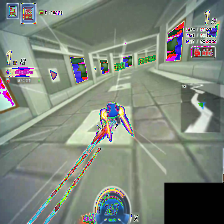

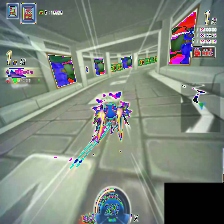

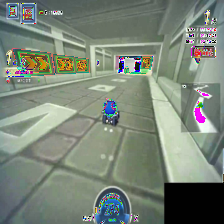

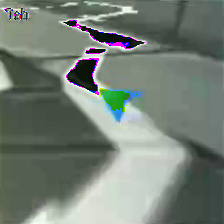

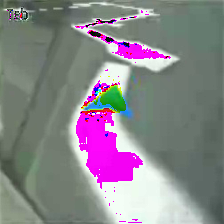

tensor([[42, 40, 32, 32, 48, 48, 32, 36, 36, 32],
        [32, 42, 40, 32, 48, 32, 32, 48, 48, 48],
        [40, 32, 32, 32, 32, 32, 48, 48, 58, 40],
        [50, 50, 48, 48, 48, 32, 32, 32, 42, 32]], device='cuda:0')
torch.Size([4, 1, 3, 224, 224])
torch.Size([4, 1])
torch.Size([4, 64])
tensor([42, 32, 40, 50], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


0
tensor(4.3709, grad_fn=<CopyBackwards>)


In [ ]:
from torchvision.transforms import ToPILImage
from IPython.display import Image
to_img = ToPILImage()
sigmoid = nn.Sigmoid()

# display(to_img(inputs[0][0]))
# display(to_img(inputs[0][1]))
# display(to_img(inputs[0][-1]))
display(to_img(images[0][0]))
display(to_img(images[0][1]))
display(to_img(images[0][-1]))

display(to_img(minimaps[0][1]))
display(to_img(minimaps[0][-1]))

images = images.to(device)
minimaps = minimaps.to(device)
speeds = speeds.to(device)
key_inputs = key_inputs.to(device)
labels = labels.to(device)
# outs, _, _ = model(images, labels)
# preds = torch.argmax(outs, dim=-1)
# print(preds)
print(labels)
print(images[:, 0].unsqueeze(1).shape)
print(labels[:, 0].unsqueeze(1).shape)
# 배치는 두고 시퀸스만 1로 만들기
outs, *hiddens = model(images[:, 0].unsqueeze(1), minimaps[:, 0].unsqueeze(1), speeds[:, 0].unsqueeze(1), key_inputs[:, 0].unsqueeze(1), None, None, None)
print(outs.shape)
preds = torch.argmax(outs, dim=-1)
print(labels[:, 0])
matches = 0
matches += (preds == labels[:, 0]).sum().item()
# matches = (labels == preds).sum().item()
print(matches)
# print(((outs > 0.5) == labels).sum(axis=1))
# print((((outs > 0.5) == labels).sum(axis=1) == 6).sum())
loss = criterion(outs, labels[:, 0])
# print(labels)
print(loss.cpu())
# print(((labels == (outs > 0.5)).sum(axis=2) == 6).sum())
# print(outs > 0.5)
# print(labels)

# 학습 진행상황 확인을 위한 wandb 설정

In [ ]:
!pip install wandb

In [ ]:
import wandb

wandb.login()

wandb: Currently logged in as: junhyeokk (use `wandb login --relogin` to force relogin)


True

In [ ]:
config = {}
config['n_epochs'] = num_epochs
config['batch_size'] = batch_size
# config['lr'] = lr

wandb.init(project="boomhill24_10")
wandb.config.update(config)

# 학습 진행 및 저장

In [ ]:
for epoch in range(num_epochs):
  model.train()
  loss_value = 0
  matches = 0
  
  for idx, train_batch in enumerate(train_loader):
    images, minimaps, speeds, key_inputs, labels = train_batch
    images = images.to(device)
    minimaps = minimaps.to(device)
    speeds = speeds.to(device)
    key_inputs = key_inputs.to(device)
    labels = labels.to(device)
    
    loss = 0
    hidden1, hidden2, hidden3 = None, None, None
    for i in range(seq_size):
      outs, hidden1, hidden2, hidden3 = model(images[:, i].unsqueeze(1), minimaps[:, i].unsqueeze(1), 
                                     speeds[:, i].unsqueeze(1), key_inputs[:, i].unsqueeze(1), hidden1, hidden2, hidden3)
      preds = torch.argmax(outs, dim=-1)
      matches += (preds == labels[:, i]).sum().item()
      # batch size만큼의 결과가 정확히 일치하면 정답으로 판단
      l = criterion(outs, labels[:, i])
      loss += l
      # Language Model 학습 참조

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss_value += loss.item()

    if (idx + 1) % log_interval == 0:
      train_loss = loss_value / log_interval
      train_acc = matches / seq_size / batch_size / log_interval
      current_lr = scheduler.get_last_lr()

      wandb.log({"epoch" : epoch, "training_loss" : train_loss, "training_acc" : train_acc, "lr" : current_lr})
      print(
          f"Epoch[{epoch + 1}/{num_epochs}]({idx + 1}/{len(train_loader)}) || ",
          f"training loss {train_loss:4.4} || training accuracy {train_acc:4.2%} || lr {current_lr}"
      )

      loss_value = 0
      matches = 0

    scheduler.step()
  
  validation_loss = 0
  validation_matches = 0
  for idx, validation_batch in enumerate(validation_loader):
    model.eval()

    images, minimaps, speeds, key_inputs, labels = validation_batch
    images = images.to(device)
    minimaps = minimaps.to(device)
    speeds = speeds.to(device)
    key_inputs = key_inputs.to(device)
    labels = labels.to(device)
    
    hidden1, hidden2, hidden3 = None, None, None
    for i in range(seq_size):
      outs, hidden1, hidden2, hidden3 = model(images[:, i].unsqueeze(1), minimaps[:, i].unsqueeze(1), 
                                     speeds[:, i].unsqueeze(1), key_inputs[:, i].unsqueeze(1), hidden1, hidden2, hidden3)
      preds = torch.argmax(outs, dim=-1)
      validation_matches += (preds == labels[:, i]).sum().item()
      # batch size만큼의 결과가 정확히 일치하면 정답으로 판단
      l = criterion(outs, labels[:, i])
      validation_loss += l.item()
      # Language Model 학습 참조
    
  validation_loss = validation_loss / len(validation_loader) 
  validation_acc = validation_matches / seq_size / batch_size / len(validation_loader)
  wandb.log({"validation_loss" : validation_loss, "validation_acc" : validation_acc})
  print(
      f"Validation[{epoch + 1}/{num_epochs}] || ",
      f"validation loss {validation_loss:4.4} || validation accuracy {validation_acc:4.2%}"
  )

Epoch[10/10](20/1053) ||  training loss 2.087 || training accuracy 95.00% || lr [9.842915805648122e-05]


KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(), save_path)

In [ ]:
inputs, key_inputs, labels = next(it)
print(inputs.shape)
print(key_inputs.shape)
print(labels.shape)
# batch, seq, channel, width, height
# batch, seq, label

display(to_img(inputs[0][0]))
# display(to_img(inputs[0][1]))
# display(to_img(inputs[0][-1]))

model.eval()

inputs = inputs.to(device)
key_inputs = key_inputs.to(device)
labels = labels.to(device)
outs, h1, h2 = model(inputs, key_inputs)
print(outs)
preds = torch.argmax(outs, dim=-1)
print(preds)
loss = criterion(outs, labels)
print(labels)
print(loss.cpu())

In [ ]:
print(labels)

In [ ]:
torch.cuda.empty_cache()

inputs, key_inputs, labels = next(it)

model.eval()

inputs = inputs.to(device)
key_inputs = key_inputs.to(device)
labels = labels.to(device)

outs, h1, h2 = model(inputs, key_inputs)

preds = torch.argmax(outs, dim=-1)
print(preds)
print(labels)

In [ ]:
model.eval()

outs, _, _ = model(inputs, key_inputs, h1, h2)

preds = torch.argmax(outs, dim=-1)
print(preds)
print(labels)

In [ ]:
model.eval()

outs, _, _ = model(inputs, key_inputs)

preds = torch.argmax(outs, dim=-1)
print(preds)
print(labels)

In [ ]:
model.eval()

h1 = None
h2 = None

idx = 100
for i in range(seq_size):
  img = dataset[idx][0][i].unsqueeze(0).unsqueeze(0).to(device)
  key = dataset[idx][1][i].unsqueeze(0).unsqueeze(0).to(device)
  out, h1, h2 = model(img, key, h1, h2)
  pred = torch.argmax(out, dim=-1)
  print(pred.item())
print(f"label : {dataset[idx][2]}")